In [1]:
import dill
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
with open("experiment_config_results_gpu","rb") as current_file:
    experiment_config_results = dill.load(current_file)
with open("experiments_gpu","rb") as current_file:
    experiments = dill.load(current_file)

    
non_unique_params = np.array([experiment['parameter'] for experiment in experiments])
non_unique_config_strings = np.array([experiment['config_string'] for experiment in experiments])

par_indices = np.unique(non_unique_params,return_index=True)[1]
string_indices = np.unique(non_unique_config_strings,return_index=True)[1]

parameters = non_unique_params[np.sort(par_indices)]
config_strings = non_unique_config_strings[np.sort(string_indices)]
# config_strings[0],config_strings[1],config_strings[2] = config_strings[2],config_strings[0],config_strings[1]
config_strings[[0,1,2]] = config_strings[[2,0,1]]
print(config_strings)

def str_noneguard(obj):
    if hasattr(obj,'__name__'):
        return obj.__name__
    if obj is None:
        return ''
    if isinstance(obj,list):
        return str([str_noneguard(x) for x in obj])
    return str(obj)


print(len(config_strings))
colors=['#4285F4','#EA4335', '#FBBC04',  '#34A853','#000000','#46BDC6',      '#46BDC6',             '#F4CCCC','#C9DAF8',            'grey','purple']
print(len(colors))
print(config_strings)
print("")
print("")

print(parameters)
print("")

parameters[[3,4,5,6,7,8,9,10,11,12]] = parameters[[-4,-3,-2,5,3,4,6,8,-1,7]]
print(parameters)



['CCEu, SD=4' 'CCE, SD=4' 'JSD, SD=4' 'CCE, SD=100' 'JSD, SD=100'
 'JSD(5), SD=100' 'JSD(5)' 'MSE, SD=4' 'MSE, SD=100' 'KLD, SD=4'
 'KLD, SD=100']
11
11
['CCEu, SD=4' 'CCE, SD=4' 'JSD, SD=4' 'CCE, SD=100' 'JSD, SD=100'
 'JSD(5), SD=100' 'JSD(5)' 'MSE, SD=4' 'MSE, SD=100' 'KLD, SD=4'
 'KLD, SD=100']


['training_method' 'activation_types' 'input_layer_type' 'encoding_dim'
 'hidden_layers' 'activity_regularizer' 'sigma' 'BN_size'
 'labeled_data_percentage' 'kernel_landmarks' 'CNN_kernel_size'
 'CNN_filters' 'sampling_density']

['training_method' 'activation_types' 'input_layer_type'
 'kernel_landmarks' 'CNN_kernel_size' 'CNN_filters' 'activity_regularizer'
 'encoding_dim' 'hidden_layers' 'sigma' 'labeled_data_percentage'
 'sampling_density' 'BN_size']


In [3]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

def plot_vals(i,ylim=[-175,100]):
    fig, ax = plt.subplots(figsize=[10,6])
#     ax.set_color_cycle(['red', 'yellow', 'blue','green','black','teal'])
#     ax.set_prop_cycle(color=['#4285F4','#FBBC04','#EA4335','#34A853','#000000','#46BDC6','#F4CCCC','#C9DAF8','grey','purple'])
    
    parameter = parameters[i]
    ax.set_title(parameter)
    bar=0
    all_numbers = True
    
    for config_index,config_string in enumerate(config_strings):
        color=colors[config_index]
    #     print("--------- " + config_string + " -----------")
        filtered_experiments = [ex for ex in experiments if ex['parameter']==parameter and ex['config_string']==config_string]
        if len(filtered_experiments)==0:
            continue
        mappings = np.array([x['mapping'] for x in filtered_experiments])
        x_values = [x['current_var'] for x in filtered_experiments]
        for x in x_values:
            if not isinstance(x,int) and not isinstance(x,float):
                all_numbers=False

        if not all_numbers:
            for i in range(len(x_values)):
                x_values[i] = str_noneguard(x_values[i])

        results = [result for result in np.array(experiment_config_results,dtype=object)[mappings] ]
        means = np.array([np.mean(x) for x in results])
        sigmas = np.array([np.std(x) for x in results])

    #     print("mappings")
    #     display(mappings)
    #     print("")
    #     print("results")
    #     display(results)
    #     print("")
    #     print("x_values")
    #     display(x_values)
    #     print("")
    #     print("means")
    #     display(means)
    #     print("")
    #     print("sigmas")
    #     display(sigmas)
    #     print("\n\n\n")
    #     ax.plot(x_values,means)
#         print(x_values)
        if all_numbers:
            ax.plot(x_values,means,'o-',label=config_string,color=color)
            ax.fill_between(x_values, (means-sigmas), (means+sigmas),alpha=.2,color=color)
        else:
            n=len(x_values)
            ind = np.arange(n)
            width = 0.1
            position = ind + (width*(1-n)/2) + bar*width
            ax.bar(position,means,width=width,yerr=sigmas,label=config_string,color=color)
            bar+=1
    
    ax.set_ylim(ylim)
    if not all_numbers:
        print(x_values)
        print(ind)
#         ax.axhline(0,"black")
        ax.yaxis.set_major_locator(MultipleLocator(25))    
        ax.grid(axis="y")
        
        plt.xticks(ind, x_values)
    else:
        ax.yaxis.set_major_locator(MultipleLocator(25))
        ax.grid()
    ax.axhline(0,color='black')
    ax.legend()

['supervised', 'supervised_2_percent', 'semi', 'semi_sup_first', 'semi_mixed', 'unsupervised']
[0 1 2 3 4 5]


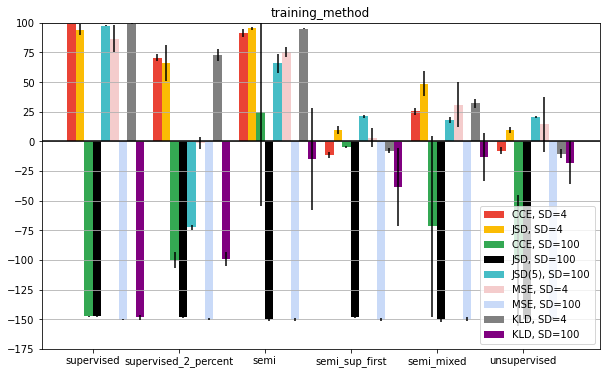

In [4]:
plot_vals(0)
plt.savefig("pictures/results_fig_0.svg")

["['sin', 'cos', 'linear', 'relu', 'swish']", "['relu']", "['relu', 'relu', 'relu', 'relu', 'relu']", "['sin', 'cos', 'linear']", "['sin', 'cos', 'linear', 'relu', 'sigmoid']"]
[0 1 2 3 4]


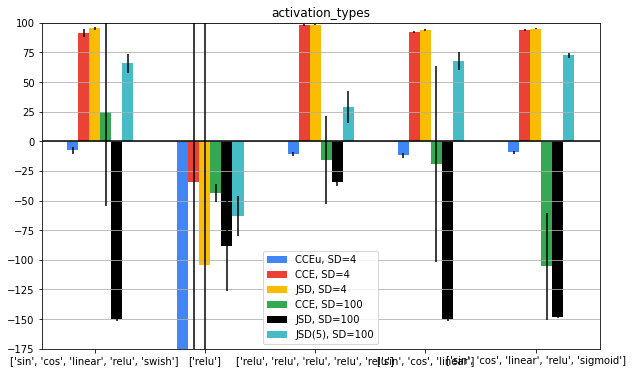

In [5]:
plot_vals(1)
plt.savefig("pictures/results_fig_1.svg")

['dense', 'gaussian_noise', 'gaussian_dropout', 'sqrt_softmax', 'gaussian_kernel', 'CNN', 'VAE']
[0 1 2 3 4 5 6]


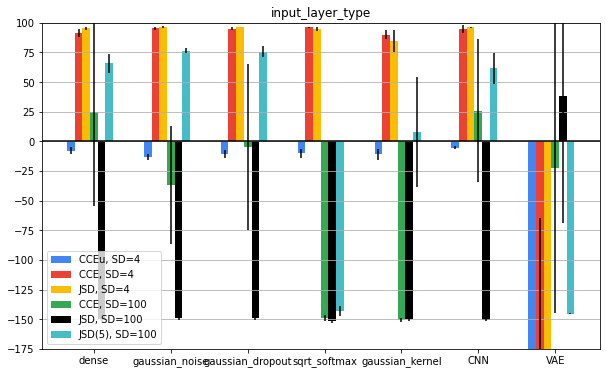

In [6]:
plot_vals(2)
plt.savefig("pictures/results_fig_2.svg")

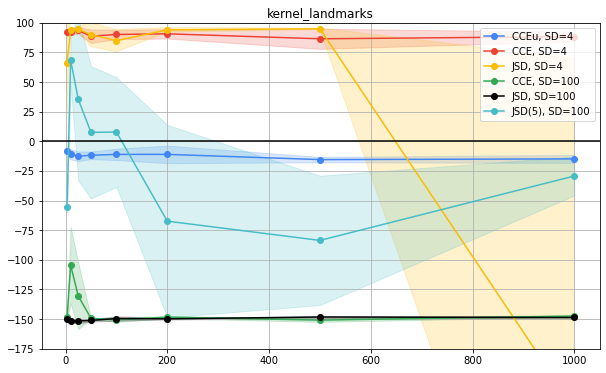

In [7]:
plot_vals(3)
plt.savefig("pictures/results_fig_3.svg")

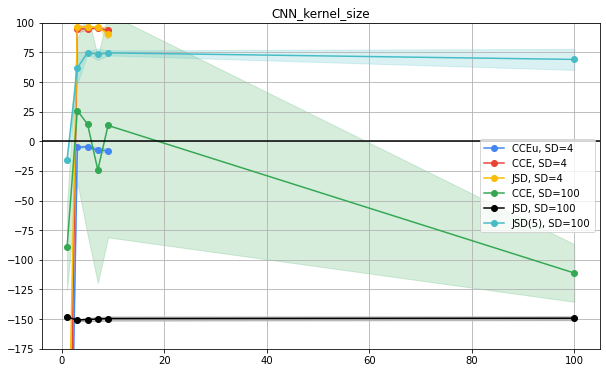

In [8]:
plot_vals(4)
plt.savefig("pictures/results_fig_4.svg")

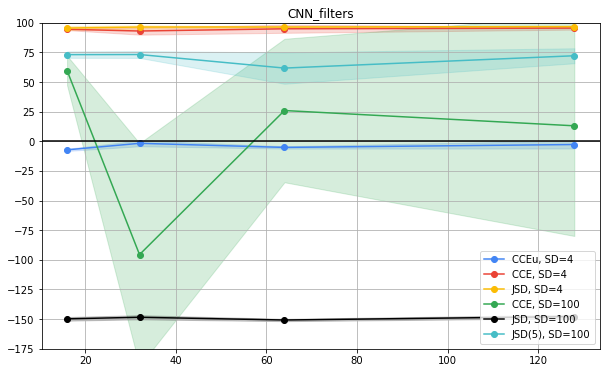

In [9]:
plot_vals(5)
plt.savefig("pictures/results_fig_5.svg")

['', 'L2: 0.01', 'L2: 10^-4', 'L1: 0.01', 'L1: 10^-4']
[0 1 2 3 4]


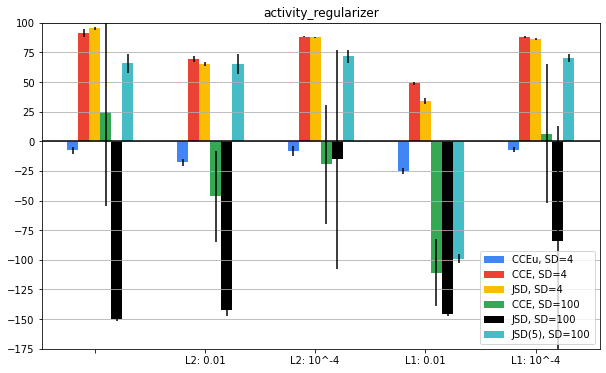

In [10]:
plot_vals(6)
plt.savefig("pictures/results_fig_6.svg")

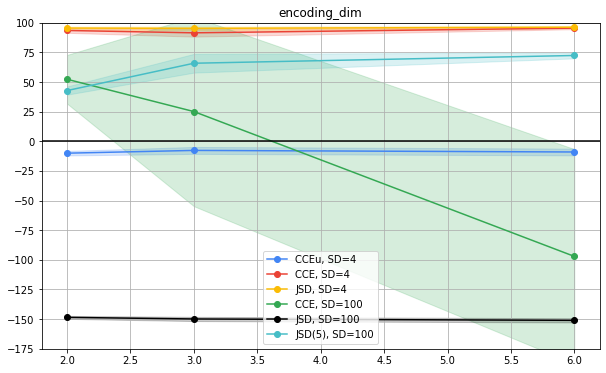

In [11]:
plot_vals(7)
plt.savefig("pictures/results_fig_7.svg")

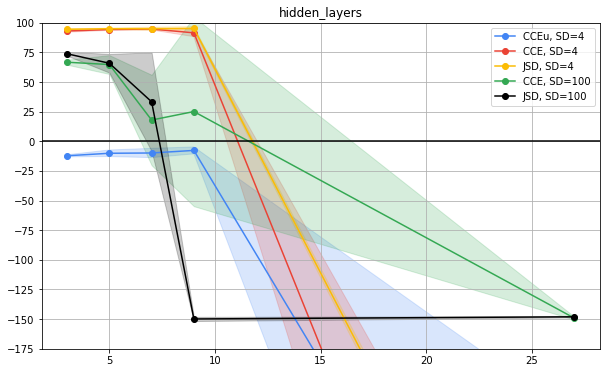

In [12]:
plot_vals(8)
plt.savefig("pictures/results_fig_8.svg")

['0.01/SD', '(0.01*4)/SD', '0.01/math.sqrt(SD)', '0.01', '0.05', '0.1', '0.2']
[0 1 2 3 4 5 6]


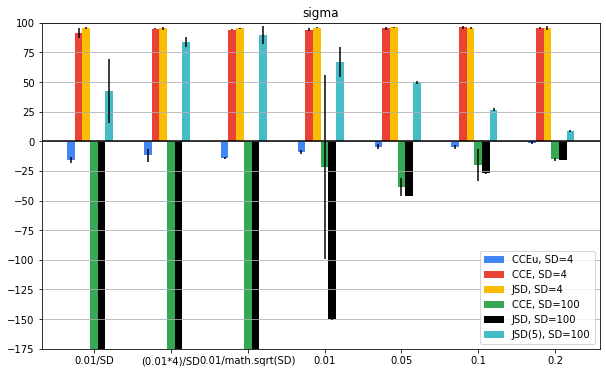

In [13]:
plot_vals(9)
plt.savefig("pictures/results_fig_9.svg")

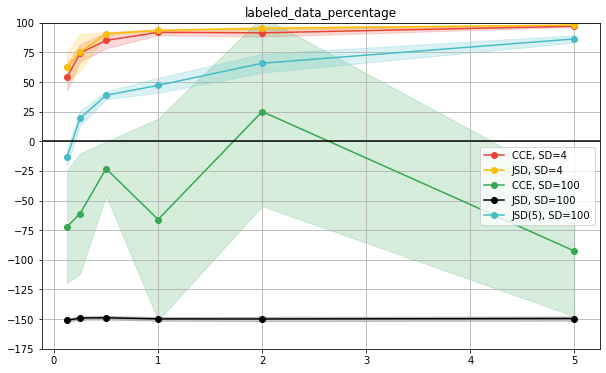

In [14]:
plot_vals(10)
plt.savefig("pictures/results_fig_10.svg")

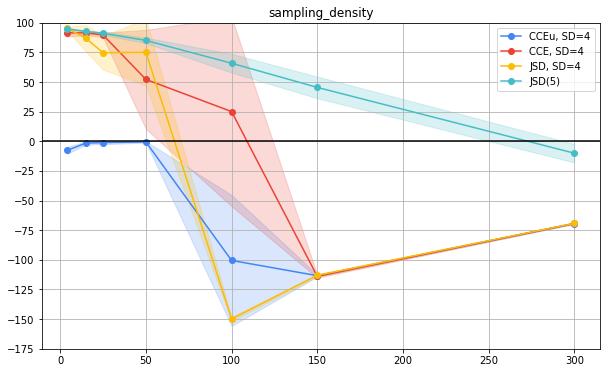

In [15]:
plot_vals(11)
plt.savefig("pictures/results_fig_11.svg")

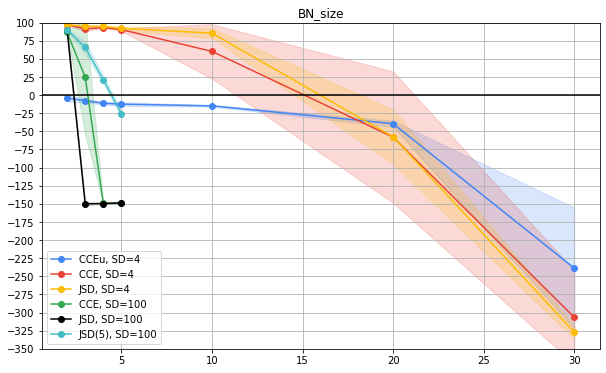

In [16]:
plot_vals(12,ylim=[-350,100])
plt.savefig("pictures/results_fig_12.svg")

In [17]:
[str(i) + " " + str(len(experiment_config_results[x['mapping']])) for i,x in enumerate(experiments)]

['0 4',
 '1 4',
 '2 4',
 '3 4',
 '4 4',
 '5 4',
 '6 4',
 '7 4',
 '8 4',
 '9 4',
 '10 4',
 '11 4',
 '12 4',
 '13 4',
 '14 4',
 '15 4',
 '16 4',
 '17 4',
 '18 4',
 '19 4',
 '20 4',
 '21 4',
 '22 4',
 '23 4',
 '24 4',
 '25 4',
 '26 4',
 '27 4',
 '28 4',
 '29 4',
 '30 4',
 '31 4',
 '32 4',
 '33 4',
 '34 4',
 '35 4',
 '36 4',
 '37 4',
 '38 4',
 '39 4',
 '40 4',
 '41 4',
 '42 4',
 '43 4',
 '44 4',
 '45 4',
 '46 4',
 '47 4',
 '48 4',
 '49 4',
 '50 4',
 '51 4',
 '52 4',
 '53 4',
 '54 4',
 '55 4',
 '56 4',
 '57 4',
 '58 4',
 '59 4',
 '60 4',
 '61 4',
 '62 4',
 '63 4',
 '64 4',
 '65 4',
 '66 4',
 '67 4',
 '68 4',
 '69 4',
 '70 4',
 '71 4',
 '72 6',
 '73 4',
 '74 4',
 '75 4',
 '76 4',
 '77 4',
 '78 4',
 '79 4',
 '80 4',
 '81 4',
 '82 4',
 '83 4',
 '84 4',
 '85 4',
 '86 4',
 '87 4',
 '88 4',
 '89 4',
 '90 4',
 '91 4',
 '92 4',
 '93 4',
 '94 4',
 '95 4',
 '96 4',
 '97 6',
 '98 4',
 '99 4',
 '100 4',
 '101 4',
 '102 4',
 '103 4',
 '104 4',
 '105 4',
 '106 4',
 '107 4',
 '108 4',
 '109 4',
 '110 4',


In [18]:
# with open("experiment_config_results_merge_1","rb") as current_file:
#     experiment_config_results1 = dill.load(current_file)
# with open("experiment_config_results_laptop","rb") as current_file:
#     experiment_config_results2 = dill.load(current_file)

# experiment_config_results = []
# for i in range(len(experiment_config_results1)):
#     exp1 = experiment_config_results1[i]
#     exp2 = experiment_config_results2[i]
#     experiment_config_results.append(exp1+exp2)

# display(experiment_config_results)
# with open("experiment_config_results_merge_final", "wb") as dill_file:
#     dill.dump(experiment_config_results, dill_file)

In [19]:
# with open("experiment_config_results_old", "wb") as dill_file:
#     dill.dump(experiment_config_results, dill_file)